In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from solver import processing
from solver import lstm

Using TensorFlow backend.


In [2]:
### FEATURE PARAMETERS
# prediction target
feature_predict = 'P_avg'
# prediction inputs from turbine data
features_train = ['P_avg', 'Ba_avg', 'Wa_avg', 'Ya_avg']
# engineered prediction inputs 
engineered_features = ['Wx', 'Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']

### TRAIN/VAL/TEST SPLIT
train_years = [2013, 2014, 2015, 2016]
validation_years = [2017]
test_years = [2017]

### TRAINING PARAMETERS:
BATCH_SIZE = 512
N_EPOCHS = 100
N_NEURONS = 64

### FEATURE ENGINEERING PARAMETERS
MA_CONSTANT = 3 # moving average smoothing parameter
N_OUT = 3 # forecast horizon
N_PAST = 48 # number of autoregression samples

In [3]:
# define datasets
TURBINE_ID = 'R80711'
DATA_DIR = os.path.join('../datasets/after_imputation', 'turbine_{}.csv'.format(TURBINE_ID))

# read datasets
dataset = processing.read_dataset(DATA_DIR)

In [4]:
# define masks for training/validation and testing (will be used later)
train_idx = dataset[dataset['Date_time'].dt.year.isin(train_years)].index
valid_idx = dataset[dataset['Date_time'].dt.year.isin(validation_years)].index
test_idx = dataset[dataset['Date_time'].dt.year.isin(test_years)].index

In [5]:
# some stats:
print("Number of duplicates: \t\t {}".format(len(dataset.index[dataset.index.duplicated()].unique())))
print("Number of rows with nan: \t {}".format(np.count_nonzero(dataset.isnull())))

# perform smoothing
if feature_predict in features_train:
    dataset = processing.smooth(dataset, cols_to_smooth=features_train, ma_constant=MA_CONSTANT)
else:
    dataset = processing.smooth(dataset, cols_to_smooth=features_train+[feature_predict], ma_constant=MA_CONSTANT)

Number of duplicates: 		 0
Number of rows with nan: 	 0


In [6]:
dataset.columns

Index(['Date_time', 'P_avg', 'Ws_avg', 'Ot_avg', 'Wa_avg', 'Ya_avg', 'Ba_avg',
       'Day sin', 'Day cos', 'Year sin', 'Year cos', 'Wx', 'Wy'],
      dtype='object')

In [7]:
# define dates for plotting
test_dates = dataset.loc[dataset['Date_time'].dt.year.isin(test_years), 'Date_time'].values

# split to training/validation/testing sets based on indices
dataset_train = dataset[dataset.index.isin(train_idx)].copy()
dataset_valid = dataset[dataset.index.isin(valid_idx)].copy()
dataset_test = dataset[dataset.index.isin(test_idx)].copy()

# define target mask for features
target_idx = np.where(dataset_train.columns == feature_predict)[0][0]
target_mask = np.zeros((dataset_train.shape[1])).astype(bool)
target_mask[target_idx] = True
# define input mask for features
input_idx = [np.where(dataset_train.columns == feat_col)[0][0] for feat_col in features_train+engineered_features]
input_mask = np.zeros((dataset_train.shape[1])).astype(bool)
input_mask[input_idx] = True

# Define scaler and fit only on training data
scaler_output = MinMaxScaler()
y_train = scaler_output.fit_transform(dataset_train.iloc[:, target_mask])
y_valid = scaler_output.transform(dataset_valid.iloc[:, target_mask])
y_test = scaler_output.transform(dataset_test.iloc[:, target_mask])
# Define scaler and fit only on training data
scaler_input = MinMaxScaler()
X_train = scaler_input.fit_transform(dataset_train.iloc[:, input_mask])
X_valid = scaler_input.transform(dataset_valid.iloc[:, input_mask])
X_test = scaler_input.transform(dataset_test.iloc[:, input_mask])

# Make small tests
assert X_train.shape[0] == y_train.shape[0]
assert X_valid.shape[0] == y_valid.shape[0]
assert X_test.shape[0] == y_test.shape[0]

In [8]:
test_dates

array(['2017-01-01T00:00:00.000000000', '2017-01-01T01:00:00.000000000',
       '2017-01-01T02:00:00.000000000', ...,
       '2017-12-31T21:00:00.000000000', '2017-12-31T22:00:00.000000000',
       '2017-12-31T23:00:00.000000000'], dtype='datetime64[ns]')

In [9]:
# make supervised learning problem
X_train_sup = processing.series_to_supervised(X_train, n_in=N_PAST, n_out=0, dropnan=True)
y_train_sup = processing.series_to_supervised(y_train, n_in=N_PAST, n_out=N_OUT, dropnan=True).iloc[:,-1]
X_valid_sup = processing.series_to_supervised(X_valid, n_in=N_PAST, n_out=0, dropnan=True)
y_valid_sup = processing.series_to_supervised(y_valid, n_in=N_PAST, n_out=N_OUT, dropnan=True).iloc[:,-1]
X_test_sup = processing.series_to_supervised(X_test, n_in=N_PAST, n_out=0, dropnan=True)
y_test_sup = processing.series_to_supervised(y_test, n_in=N_PAST, n_out=N_OUT, dropnan=True).iloc[:,-1]

# Align X with y
X_train_sup = X_train_sup[X_train_sup.index.isin(y_train_sup.index)]
X_valid_sup = X_valid_sup[X_valid_sup.index.isin(y_valid_sup.index)]
X_test_sup = X_test_sup[X_test_sup.index.isin(y_test_sup.index)]

# Set to numpy arrays
X_train = X_train_sup.values
y_train = y_train_sup.values
X_valid = X_valid_sup.values
y_valid = y_valid_sup.values
X_test = X_test_sup.values
y_test = y_test_sup.values

In [10]:
# FIT MODEL
lstm_model, history = lstm.fit_lstm(
    X_train, y_train, 
    X_valid, y_valid, 
    BATCH_SIZE, N_EPOCHS, N_NEURONS, 
    n_past=N_PAST)

Train on 35012 samples, validate on 8710 samples
Epoch 1/2
35012/35012 [==============================] - 129s 4ms/step - loss: 0.0278 - val_loss: 0.0221
Epoch 2/2
35012/35012 [==============================] - 111s 3ms/step - loss: 0.0177 - val_loss: 0.0161


MAE: 193.539 RMSE: 261.043 sMAPE: 0.782


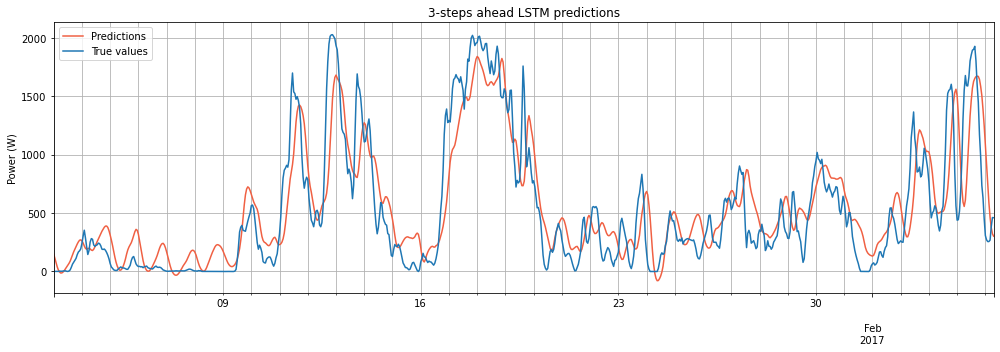

In [12]:
# evaluate predictions
y_predict, y_true = lstm.make_predictions(lstm_model, X_valid, y_valid, scaler_output, N_PAST)

# plot predictions
predictions = pd.Series(y_predict, index=test_dates[N_PAST:-N_OUT+1])
true = pd.Series(y_true, index=test_dates[N_PAST:-N_OUT+1])
processing.plot_series_predictions(true, predictions, N_OUT=N_OUT, method='LSTM')

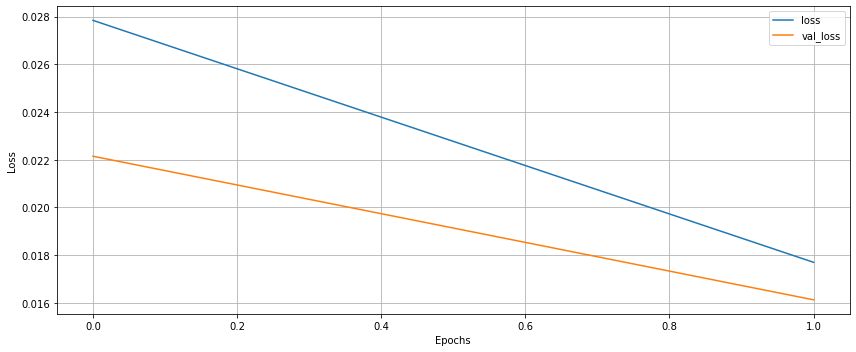

In [14]:
# plot training/validation loss
processing.plot_history(history)